<a href="https://colab.research.google.com/github/Radhesh-Sarma/Emotion-Detection/blob/main/Genetic_Algorithm_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install deap
!pip install scoop

In [6]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from deap import creator, base, tools, algorithms
from scoop import futures
import random
import numpy
from scipy import interpolate
import matplotlib.pyplot as plt

In [7]:
def normalize(dataset):
    dataNorm=((dataset-dataset.mean())/(dataset.std()))
    dataNorm["Sad?"]=dataset["Sad?"]
    return dataNorm

In [8]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [12]:
# Read in data from CSV
# Data set from https://archive.ics.uci.edu/ml/datasets/Bank+Marketing
df = pd.read_csv('gdrive/My Drive/combined.csv')
df=df.drop(['face'],1)
df=df.drop(['Unnamed: 1'],1)
print(df)
dfData=df
  
df = normalize(df)
#df=df.drop('Unnamed: 1',axis=1,inplace=True)

import numpy as np
x = np.array(df.drop(['Sad?'],1))
y = np.array(df['Sad?'])
#dfData = pd.read_csv('bank-additional-full.csv', sep=';')

     Sad?  confidence  gaze_0_x  gaze_0_y  ...  AU25_c  AU26_c  AU28_c  AU45_c
0       1       0.975  0.045100  0.261753  ...     0.0     0.0     1.0     0.0
1       1       0.925  0.058224  0.235082  ...     0.0     0.0     0.0     0.0
2       1       0.975  0.074234  0.026665  ...     0.0     0.0     0.0     0.0
3       1       0.025  0.256086 -0.216004  ...     1.0     0.0     1.0     0.0
4       1       0.975  0.193449  0.209023  ...     0.0     0.0     1.0     0.0
..    ...         ...       ...       ...  ...     ...     ...     ...     ...
121     0       0.875 -0.263258 -0.049040  ...     1.0     0.0     1.0     1.0
122     0       0.775  0.509802 -0.322897  ...     0.0     0.0     1.0     0.0
123     0       0.975  0.183691  0.158997  ...     1.0     1.0     0.0     0.0
124     0       0.975 -0.010093  0.216590  ...     0.0     0.0     1.0     0.0
125     0       0.975  0.145005  0.166456  ...     1.0     0.0     0.0     0.0

[126 rows x 711 columns]



Test accuracy with all features: 	0.75
Validation accuracy with all features: 	0.6923076923076923

gen	nevals	avg  	std      	min	max 
0  	100   	0.735	0.0517204	0.6	0.85
1  	61    	0.753	0.0405093	0.65	0.85
2  	66    	0.757	0.0458367	0.65	0.85
3  	56    	0.764	0.048    	0.6 	0.85
4  	69    	0.7615	0.0499274	0.65	0.85
5  	60    	0.776 	0.0526688	0.6 	0.85
6  	63    	0.775 	0.0531507	0.6 	0.85
7  	47    	0.7805	0.0565221	0.6 	0.85
8  	60    	0.7825	0.0535607	0.6 	0.85
9  	62    	0.792 	0.0564447	0.65	0.85
10 	63    	0.8025	0.059739 	0.65	0.85

---Optimal Feature Subset(s)---

Percentile: 			0.4283513097072419
Validation Accuracy: 		0.8846153846153846
Individual: 	[1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 

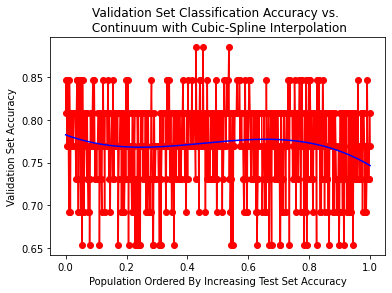

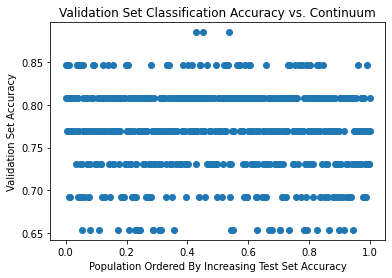

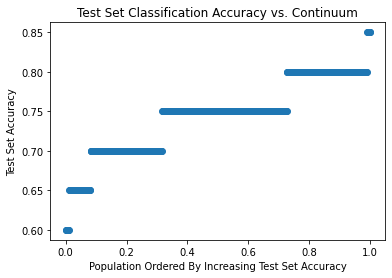

In [21]:
# Encode the classification labels to numbers
# Get classes and one hot encoded feature vectors
import warnings
warnings.filterwarnings("ignore")
le = LabelEncoder()
le.fit(dfData['Sad?'])
allClasses = le.transform(dfData['Sad?'])
allFeatures = dfData.drop(['Sad?'], axis=1)

# Form training, test, and validation sets
X_trainAndTest, X_validation, y_trainAndTest, y_validation = train_test_split(allFeatures, allClasses, test_size=0.20, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_trainAndTest, y_trainAndTest, test_size=0.20, random_state=42)

# Feature subset fitness function
def getFitness(individual, X_train, X_test, y_train, y_test):

	# Parse our feature columns that we don't use
	# Apply one hot encoding to the features
	cols = [index for index in range(len(individual)) if individual[index] == 0]
	X_trainParsed = X_train.drop(X_train.columns[cols], axis=1)
	X_trainOhFeatures = pd.get_dummies(X_trainParsed)
	X_testParsed = X_test.drop(X_test.columns[cols], axis=1)
	X_testOhFeatures = pd.get_dummies(X_testParsed)

	# Remove any columns that aren't in both the training and test sets
	sharedFeatures = set(X_trainOhFeatures.columns) & set(X_testOhFeatures.columns)
	removeFromTrain = set(X_trainOhFeatures.columns) - sharedFeatures
	removeFromTest = set(X_testOhFeatures.columns) - sharedFeatures
	X_trainOhFeatures = X_trainOhFeatures.drop(list(removeFromTrain), axis=1)
	X_testOhFeatures = X_testOhFeatures.drop(list(removeFromTest), axis=1)

	# Apply logistic regression on the data, and calculate accuracy
	clf = LogisticRegression()
	clf.fit(X_trainOhFeatures, y_train)
	predictions = clf.predict(X_testOhFeatures)
	accuracy = accuracy_score(y_test, predictions)

	# Return calculated accuracy as fitness
	return (accuracy,)

#========DEAP GLOBAL VARIABLES (viewable by SCOOP)========

# Create Individual
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

# Create Toolbox
toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, len(dfData.columns) - 1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Continue filling toolbox...
toolbox.register("evaluate", getFitness, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)
toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

#========

def getHof():

	# Initialize variables to use eaSimple
	numPop = 100
	numGen = 10
	pop = toolbox.population(n=numPop)
	hof = tools.HallOfFame(numPop * numGen)
	stats = tools.Statistics(lambda ind: ind.fitness.values)
	stats.register("avg", numpy.mean)
	stats.register("std", numpy.std)
	stats.register("min", numpy.min)
	stats.register("max", numpy.max)

	# Launch genetic algorithm
	pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=numGen, stats=stats, halloffame=hof, verbose=True)

	# Return the hall of fame
	return hof

def getMetrics(hof):

	# Get list of percentiles in the hall of fame
	percentileList = [i / (len(hof) - 1) for i in range(len(hof))]
	
	# Gather fitness data from each percentile
	testAccuracyList = []
	validationAccuracyList = []
	individualList = []
	for individual in hof:
		testAccuracy = individual.fitness.values
		validationAccuracy = getFitness(individual, X_trainAndTest, X_validation, y_trainAndTest, y_validation)
		testAccuracyList.append(testAccuracy[0])
		validationAccuracyList.append(validationAccuracy[0])
		individualList.append(individual)
	testAccuracyList.reverse()
	validationAccuracyList.reverse()
	return testAccuracyList, validationAccuracyList, individualList, percentileList


if __name__ == '__main__':

	'''
	First, we will apply logistic regression using all the features to acquire a baseline accuracy.
	'''
	individual = [1 for i in range(len(allFeatures.columns))]
	testAccuracy = getFitness(individual, X_train, X_test, y_train, y_test)
	validationAccuracy = getFitness(individual, X_trainAndTest, X_validation, y_trainAndTest, y_validation)
	print('\nTest accuracy with all features: \t' + str(testAccuracy[0]))
	print('Validation accuracy with all features: \t' + str(validationAccuracy[0]) + '\n')

	'''
	Now, we will apply a genetic algorithm to choose a subset of features that gives a better accuracy than the baseline.
	'''
	hof = getHof()
	testAccuracyList, validationAccuracyList, individualList, percentileList = getMetrics(hof)

	# Get a list of subsets that performed best on validation data
	maxValAccSubsetIndicies = [index for index in range(len(validationAccuracyList)) if validationAccuracyList[index] == max(validationAccuracyList)]
	maxValIndividuals = [individualList[index] for index in maxValAccSubsetIndicies]
	maxValSubsets = [[list(allFeatures)[index] for index in range(len(individual)) if individual[index] == 1] for individual in maxValIndividuals]

	print('\n---Optimal Feature Subset(s)---\n')
	for index in range(len(maxValAccSubsetIndicies)):
		print('Percentile: \t\t\t' + str(percentileList[maxValAccSubsetIndicies[index]]))
		print('Validation Accuracy: \t\t' + str(validationAccuracyList[maxValAccSubsetIndicies[index]]))
		print('Individual: \t' + str(maxValIndividuals[index]))
		print('Number Features In Subset: \t' + str(len(maxValSubsets[index])))
		print('Feature Subset: ' + str(maxValSubsets[index]))

	'''
	Now, we plot the test and validation classification accuracy to see how these numbers change as we move from our worst feature subsets to the 
	best feature subsets found by the genetic algorithm.
	'''
	# Calculate best fit line for validation classification accuracy (non-linear)
	tck = interpolate.splrep(percentileList, validationAccuracyList, s=5.0)
	ynew = interpolate.splev(percentileList, tck)

	e = plt.figure(1)
	plt.plot(percentileList, validationAccuracyList, marker='o', color='r')
	plt.plot(percentileList, ynew, color='b')
	plt.title('Validation Set Classification Accuracy vs. \n Continuum with Cubic-Spline Interpolation')
	plt.xlabel('Population Ordered By Increasing Test Set Accuracy')
	plt.ylabel('Validation Set Accuracy')
	e.show()

	f = plt.figure(2)
	plt.scatter(percentileList, validationAccuracyList)
	plt.title('Validation Set Classification Accuracy vs. Continuum')
	plt.xlabel('Population Ordered By Increasing Test Set Accuracy')
	plt.ylabel('Validation Set Accuracy')
	f.show()

	g = plt.figure(3)
	plt.scatter(percentileList, testAccuracyList)
	plt.title('Test Set Classification Accuracy vs. Continuum')
	plt.xlabel('Population Ordered By Increasing Test Set Accuracy')
	plt.ylabel('Test Set Accuracy')
	g.show()

	input()